<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Astronomy_Galaxy_Classification_(DNN)_solution_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Galaxy classification using fully-connected neural networks

In this notebook, we attempt to classify galaxies according to their shape using fully connected DNN.


The data in this example is a subset of the [Galaxy10 dataset](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/). The images are categorized according to their shapes. We use a slimmed down dataset which contains 8 classes:

'Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge'.


The aim of this work is to train a neural network to classify the galaxy images.

In [9]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called sciml-workshop-data.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [10]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Astronomy')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Astronomy/"
files_to_download = ["Galaxy8.h5"]

In [11]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The slimmed down dataset, which include the images with 8 labels, are stored in the h5 file `Astronomy/Galaxy8.h5`. We load this file using a `h5py` library.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])
```
    
</p>
</details>

In [12]:
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])

In [13]:
# downsample the images - so that the model fits in memory.
x = x[:, ::2, ::2]

# normalise images
x = x / 255.0

# split train test
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)


# string labels
string_labels = ['Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral',
                 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0, :, :, 0].shape))
print("Number of channels: %s" % str(train_images.shape[-1]))


Number of training data: 6400
Number of test data: 1600
Image pixels: (64, 64)
Number of channels: 3


### We can randomly plot some images and their labels

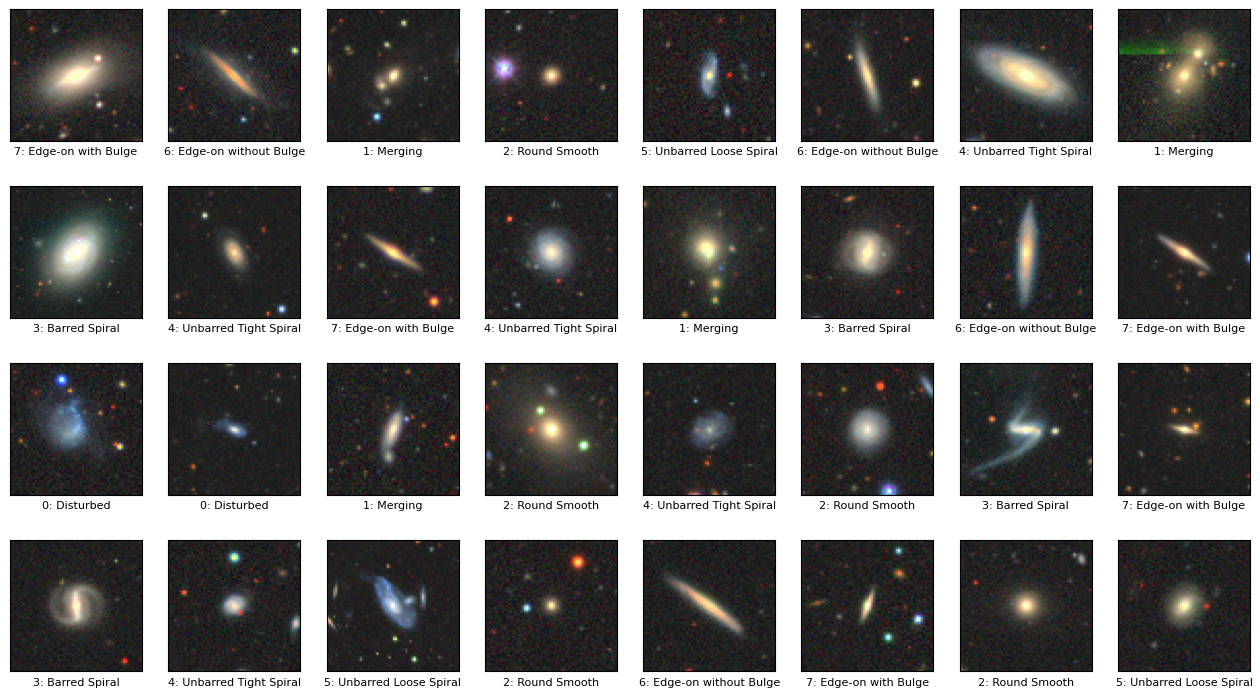

In [14]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])

# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

In this case, we have 8 classes. Hence, the number of the outputs is 8. Then, we use 'SparseCategoricalCrossentropy' and will see 'accuracy' while training the model.



**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Flatten(input_shape=(64, 64, 3)))
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>


In [15]:
# build the network architecture
model = Sequential()
model.add(Input(shape=(64, 64, 3)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,716,168 (48.51 MB)

 Trainable params: 12,716,168 (48.51 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │    12,583,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,716,168 (48.51 MB)

 Trainable params: 12,716,168 (48.51 MB)

 Non-trainable params: 0 (0.00 B)

### Compile and train the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                             validation_data=(test_images, test_labels))
```
    
</p>
</details>

In [16]:
# compile the model
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                             validation_data=(test_images, test_labels))

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.1802 - loss: 2.7804 - val_accuracy: 0.2850 - val_loss: 1.9200
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2739 - loss: 1.8654 - val_accuracy: 0.2937 - val_loss: 1.7699
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3257 - loss: 1.7379 - val_accuracy: 0.3106 - val_loss: 1.8056
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3749 - loss: 1.6403 - val_accuracy: 0.3550 - val_loss: 1.7480
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4461 - loss: 1.5003 - val_accuracy: 0.3369 - val_loss: 1.7472
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4950 - loss: 1.3415 - val_accuracy: 0.4200 - val_loss: 1.5408
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5619 - loss: 1.1613 - val_accuracy: 0.4181 - val_loss: 1.6376
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5909 - loss: 1.0871 - val_accuracy: 0.

---

# 3. Analyse results

### Check training history

We can examine the training history by plotting accuracy and loss against epoch for both the training and the test data.

Notice that the accuracies for the training and the test data diverge as the model trains. This is a classic symptom of [overfitting](https://en.wikipedia.org/wiki/Overfitting), that is, our model corresponds too closely to the training data so that it cannot fit the test data with an equivalent accuracy.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

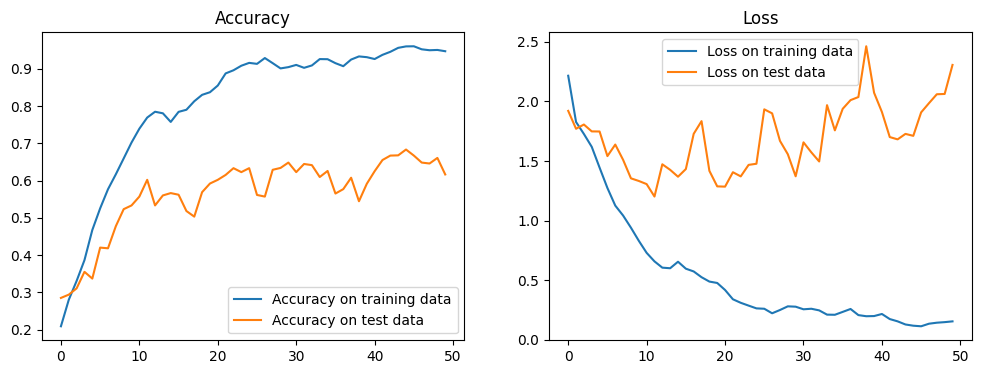

In [17]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

---

# 4. Regularise and re-train

Dropout, also called dilution, is a regularisation technique to mitigate against overfitting by randomly omitting a certain amount of neurons from a layer. Here we will rebuild our model with `Dropout` between the hidden and the output layers. Let us see whether this can negate the overfitting or not.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the network architecture
model_reg = Sequential()
model_reg.add(Flatten(input_shape=(64, 64, 3)))
model_reg.add(Dense(1024, activation='relu'))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dense(8, activation='sigmoid'))

# compile the model
model_reg.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
```
    
</p>
</details>

In [21]:
# build the network architecture
model_reg = Sequential()
model_reg.add(Input(shape=(64, 64, 3)))
model_reg.add(Flatten())
model_reg.add(Dense(1024, activation='relu'))
model_reg.add(Dropout(0.1))
model_reg.add(Dense(128, activation='relu'))
model_reg.add(Dense(8, activation='sigmoid'))

# compile the model
model_reg.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

In [22]:
# train the model
training_history_reg = model_reg.fit(train_images, train_labels, epochs=50, batch_size=32,
                                     validation_data=(test_images, test_labels))

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1605 - loss: 2.6814 - val_accuracy: 0.2387 - val_loss: 1.9017
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2523 - loss: 1.8905 - val_accuracy: 0.2512 - val_loss: 1.8268
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2822 - loss: 1.8201 - val_accuracy: 0.3156 - val_loss: 1.7984
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3199 - loss: 1.7399 - val_accuracy: 0.2988 - val_loss: 1.7840
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3439 - loss: 1.6529 - val_accuracy: 0.3669 - val_loss: 1.6605
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3928 - loss: 1.5544 - val_accuracy: 0.3931 - val_loss: 1.5840
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4504 - loss: 1.4332 - val_accuracy: 0.4494 - val_loss: 1.4606
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4930 - loss: 1.3370 - val_accuracy: 0.

### Compare training histories with and without dropout

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history_reg.history[acc_str], label='Accuracy on training data')
plt.plot(training_history_reg.history['val_' + acc_str], label='Accuracy on test data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data (no dropout)')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history_reg.history['loss'], label='Loss on training data')
plt.plot(training_history_reg.history['val_loss'], label='Loss on test data')
plt.plot(training_history.history['val_loss'], label='Loss on test data (no dropout)')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

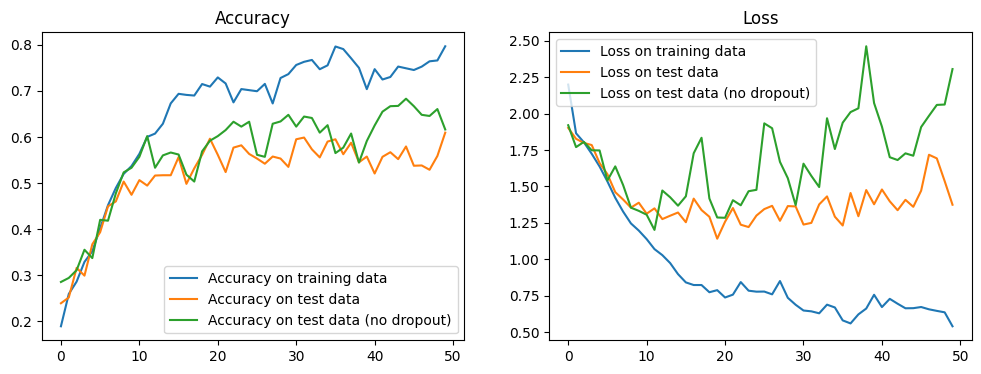

In [23]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history_reg.history[acc_str], label='Accuracy on training data')
plt.plot(training_history_reg.history['val_' + acc_str], label='Accuracy on test data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data (no dropout)')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history_reg.history['loss'], label='Loss on training data')
plt.plot(training_history_reg.history['val_loss'], label='Loss on test data')
plt.plot(training_history.history['val_loss'], label='Loss on test data (no dropout)')
plt.legend()
plt.title("Loss")
plt.show()

### Make predictions

Finally, we can use our trained model to make predictions. Here we show some wrong predictions for the test data, from which we may get some ideas about what kinds of images baffle our model.

In [24]:
# use test images to make predictions
pred_lables = model_reg.predict(test_images).argmax(axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Number of test data: 1600
Number of wrong predictions: 625


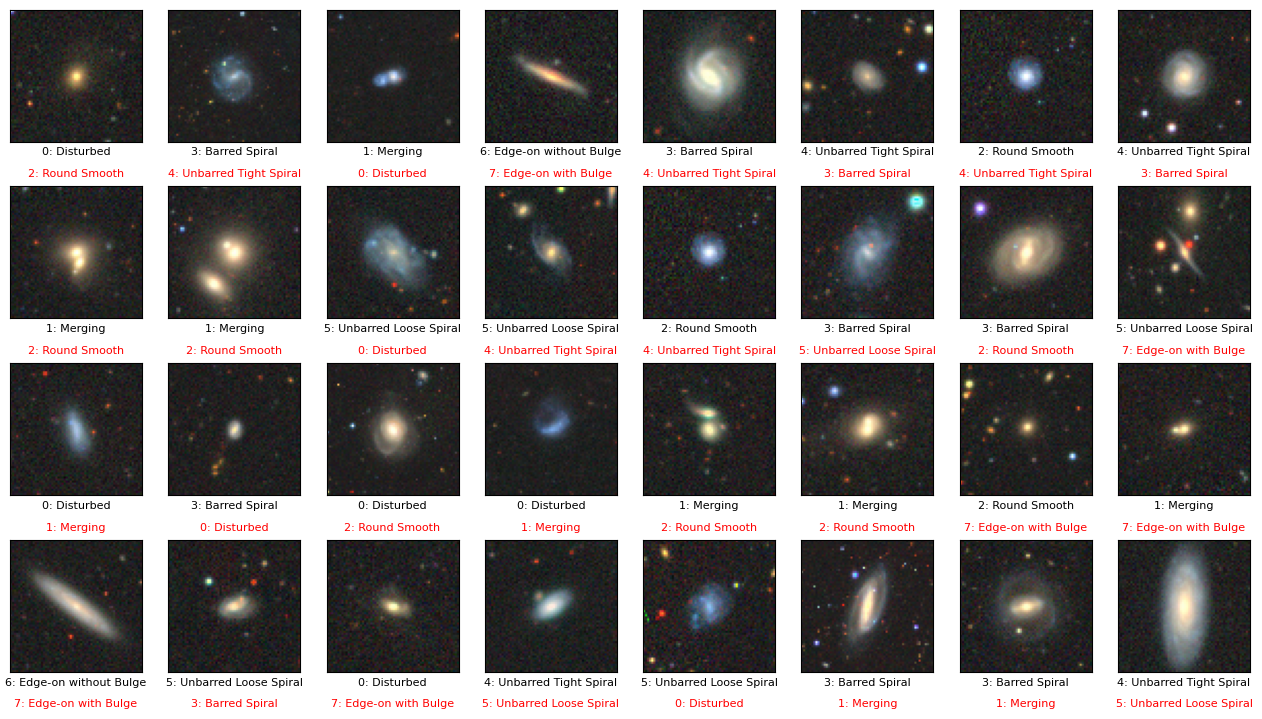

In [25]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 5. Exercises

* Change some hyperparameters in `model.compile()` and `model.fit()` to see their effects (see reference of [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model));
* Regularise the network and re-train